In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras import datasets, layers, models


from keras.layers import Dense
from keras import datasets, layers, models
import math

from sklearn.cluster import KMeans
import tensorflow as tf
from keras import layers, datasets, models
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense



In [ ]:
df = pd.read_csv("/content/Train.csv")

In [ ]:
# df.dropna(subset=['PM2.5'], inplace=True)
features = ['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN']
df.dropna(subset=features, inplace=True)

In [ ]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [ ]:
# Assuming 'df' is your DataFrame containing the dataset
# Selecting the specified features: PM2.5, TEMP, NO2, SO2, DEWP, O3, WSPM, RAIN
# Adjust the column indices according to your DataFrame structure
features_columns = ['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN']  # Use the actual column names from your DataFrame

# Select all rows for these features
training_set = df[features_columns].values

# Check the length of the training_set
length_of_training_set = len(training_set)
print(length_of_training_set)

25977


In [ ]:
training_set = training_set[-5000:]

**Feature Scaling**

In [ ]:
# normalize your data for CNN-LSTM
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
lag = 48  # Number of hours to use as input to predict the next hour.
n_obs = 5000  # Total number of hourly observations in your training set.
features = 8  # Total number of features included

X_train = []
y_train = []

for i in range(lag, n_obs):
    X_train.append(training_set_scaled[i-lag:i, :])  # The previous 48 hours' data.2 days
    y_train.append(training_set_scaled[i, 0])  # The current hour's data to predict.

# Convert lists to numpy arrays for training the CNN-LSTM.
X_train, y_train = np.array(X_train), np.array(y_train)

# Now, X_train should have the shape [samples, timesteps, features]
print(X_train.shape)  # Expected shape: (number of samples, lag, features)

(4952, 48, 8)


In [ ]:
X_train.shape

(4952, 48, 8)

# **CNN LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, Dropout

model = Sequential()

# Define the number of time steps and features for the CNN layers
n_steps, n_features, n_seq = 4, 8, X_train.shape[1] // 4 # Set n_features to 8
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))

# CNN layers wrapped in TimeDistributed to allow for sequence processing
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(Bidirectional(LSTM(50)))

# Output layer
model.add(Dense(1))

In [ ]:
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, None, 4, 64)       576       
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, None, 2, 64)       0         
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 128)         0         
 istributed)                                                     
                                                                 
 bidirectional_4 (Bidirecti  (None, 100)               71600     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 1)                

Fitting the CNN-LSTM to the Training set

In [ ]:
# Compiling the CNN-LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
155/155 [==============================] - 8s 18ms/step - loss: 0.0040
Epoch 2/50
155/155 [==============================] - 3s 18ms/step - loss: 0.0018
Epoch 3/50
155/155 [==============================] - 3s 18ms/step - loss: 0.0013
Epoch 4/50
155/155 [==============================] - 4s 26ms/step - loss: 0.0012
Epoch 5/50
155/155 [==============================] - 3s 18ms/step - loss: 0.0011
Epoch 6/50
155/155 [==============================] - 3s 18ms/step - loss: 0.0011
Epoch 7/50
155/155 [==============================] - 3s 18ms/step - loss: 0.0011
Epoch 8/50
155/155 [==============================] - 4s 25ms/step - loss: 0.0010
Epoch 9/50
155/155 [==============================] - 3s 20ms/step - loss: 0.0010
Epoch 10/50
155/155 [==============================] - 3s 19ms/step - loss: 9.7058e-04
Epoch 11/50
155/155 [==============================] - 3s 20ms/step - loss: 0.0010
Epoch 12/50
155/155 [==============================] - 4s 26ms/step - loss: 0.0010
Epoch 13/

Making the predictions and visualising the results

In [ ]:
# transform and create sequences for Test data
dataset_test = pd.read_csv('/content/Test.csv')


In [ ]:
# Assuming 'sc' is your MinMaxScaler fitted on the training data

# Drop rows with NaN values in any of the columns you're using
dataset_test.dropna(subset=['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN'], inplace=True)

# Scale the test data using the same scaler as the training data
# Make sure to select the same features in the same order as the training set
test_features = dataset_test[['PM2.5', 'TEMP', 'NO2', 'SO2', 'DEWP', 'O3', 'WSPM', 'RAIN']].values
test_features_scaled = sc.transform(test_features)

# Prepare sequences for testing
X_test = []
for i in range(lag, len(test_features_scaled)):
    X_test.append(test_features_scaled[i-lag:i]) # Use all features

X_test = np.array(X_test)

# Reshape X_test if necessary (it might already be in the correct shape)
# X_test should now be shaped [samples, timesteps, features]
# No need to reshape based on the previous step since it already considers all features

# Make predictions


In [ ]:
# Reshape X_test to match the expected input shape of the model
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1] // n_steps, n_steps, n_features))

# Make predictions
pred_PM2 = model.predict(X_test)

207/207 [==============================] - 2s 6ms/step


In [ ]:
# real_PM2 = dataset_test['PM2.5'].values
# real_PM2

In [ ]:
# Assume pred_PM2 is your predictions with shape (num_samples, 1)
# Create an array with the same number of columns as the original scaled data
pred_full = np.zeros((pred_PM2.shape[0], 8))  # 8 for the number of features you have

# Assuming PM2.5 is the first column, fill in your predictions there
pred_full[:, 0] = pred_PM2.ravel()  # Use ravel() to ensure it's a 1D array

# Perform the inverse transformation
pred_full_inverse = sc.inverse_transform(pred_full)

# Extract the PM2.5 predictions after inverse transforming
pred_PM2_inverse = pred_full_inverse[:, 0]

In [ ]:
# data_set_total.reset_index(drop=True, inplace=True)

In [ ]:
# Assuming dataset_test is your test DataFrame and it's already preprocessed to drop NaNs as before
real_PM2 = dataset_test['PM2.5'].values[-len(pred_PM2):]  # Make sure to align the lengths

# Ensure real_PM2 is properly shaped for comparison
# If necessary, reshape it (though it should already be a 1D array matching pred_PM2_inverse in length)
real_PM2 = real_PM2.reshape(-1, 1)  # Only needed if real_PM2 isn't already a 1D array

# Now proceed with RMSE calculation
RMSE = np.sqrt(np.mean((pred_PM2_inverse - real_PM2.ravel())**2))  # Use ravel() to ensure it's 1D for calculation
print("RMSE:", RMSE)

RMSE: 25.678627100267086


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_PM2.ravel(), pred_PM2_inverse))

# Calculate MAE
mae = mean_absolute_error(real_PM2.ravel(), pred_PM2_inverse)

# Calculate MSE
mse = mean_squared_error(real_PM2.ravel(), pred_PM2_inverse)

# Calculate MAPE - Note: You have to ensure real_PM2 does not contain zeros to avoid division by zero
mape = np.mean(np.abs((real_PM2.ravel() - pred_PM2_inverse) / real_PM2.ravel())) * 100

# Calculate R-squared
r2 = r2_score(real_PM2.ravel(), pred_PM2_inverse)

# Print the results
print('RMSE: {:.4f}'.format(rmse))
print('MAE: {:.4f}'.format(mae))
print('MSE: {:.4f}'.format(mse))
print('MAPE: {:.4f}%'.format(mape))
print('R-squared: {:.4f}'.format(r2))

RMSE: 25.6786
MAE: 16.3269
MSE: 659.3919
MAPE: 46.4035%
R-squared: 0.9084


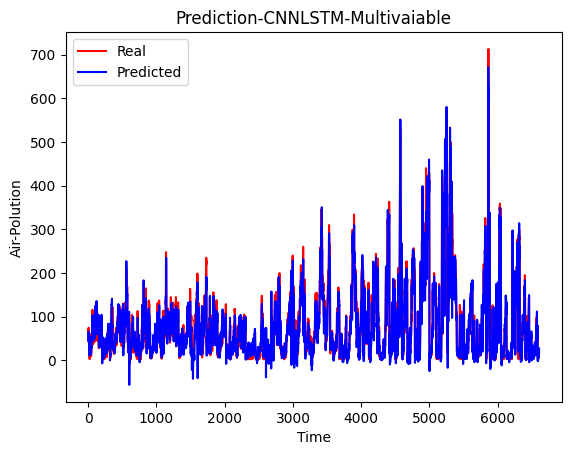

In [ ]:
plt.plot(real_PM2.ravel(), color = 'red', label = 'Real')
plt.plot(pred_PM2_inverse, color = 'blue', label = 'Predicted')
plt.title('Prediction-CNNLSTM-Multivaiable')
plt.xlabel('Time')
plt.ylabel('Air-Polution')
plt.legend()
plt.show()